In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pycountry
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style('darkgrid')
sns.set_palette('colorblind')

In [2]:
LATEST_CASES_PATH_CSV = 'data/cases-per-day.csv'
LATEST_CASES_PATH_XLSX = 'data/cases-per-day.xlsx'

In [3]:
df = pd.read_excel(LATEST_CASES_PATH_XLSX, parse_dates=[0], encoding='iso-8859-1', index_col=0).rename(
    columns={
        'dateRep': 'date', 
        'countriesAndTerritories': 'geo_name', 
        'geoId': 'geo_id',
        'popData2018': 'pop_data_2018'
    },
    index={'dateRep': 'date'}
)
df.index.names = ['date']
df = df.drop(columns=['day', 'month', 'year', 'countryterritoryCode'])
df['geo_name'] = df['geo_name'].apply(lambda s: s.replace('_', ' '))

df

,cases,deaths,geo_name,geo_id,pop_data_2018
date,,,,,
2020-03-30,8,1,Afghanistan,AF,37172386.0
2020-03-29,15,1,Afghanistan,AF,37172386.0
2020-03-28,16,1,Afghanistan,AF,37172386.0
2020-03-27,0,0,Afghanistan,AF,37172386.0
2020-03-26,33,0,Afghanistan,AF,37172386.0
...,...,...,...,...,...
2020-03-25,0,0,Zimbabwe,ZW,14439018.0
2020-03-24,0,1,Zimbabwe,ZW,14439018.0
2020-03-23,0,0,Zimbabwe,ZW,14439018.0


In [4]:
lockdowns_raw = [
    ['2020-03-23', 'UK'],
    ['2020-03-01', 'IT'],
    ['2020-03-08', 'IT'],

]
lockdowns = pd.DataFrame(np.array(lockdowns_raw), columns=['lockdown_date', 'country_code'])
lockdowns['lockdown_date'] = lockdowns['lockdown_date'].apply(lambda d: np.datetime64(d))

lockdowns.set_index('lockdown_date', inplace=True)

lockdowns

,country_code
lockdown_date,
2020-03-23,UK
2020-03-01,IT
2020-03-08,IT


In [5]:
def rank_index(df):
    new_df = df.reset_index()
    new_df.index += 1
    
    return new_df.drop(columns=['index'])

In [6]:
aggregated = df.groupby(['geo_id', 'pop_data_2018', 'geo_name'], as_index=False)[['cases', 'deaths']].sum()

aggregated['cases_per_100k'] = aggregated['cases'] / (aggregated['pop_data_2018'] / 10 ** 5)
aggregated['deaths_per_100k'] = aggregated['deaths'] / (aggregated['pop_data_2018'] / 10 ** 5)
aggregated = aggregated.sort_values(by=['cases_per_100k'], ascending=False)
aggregated = rank_index(aggregated)

aggregated

,geo_id,pop_data_2018,geo_name,cases,deaths,cases_per_100k,deaths_per_100k
1,JPG11668,3000.0,Cases on an international conveyance Japan,696,7,23200.000000,233.333333
2,SM,33785.0,San Marino,229,24,677.815599,71.037443
3,VA,1000.0,Holy See,6,0,600.000000,0.000000
4,AD,77006.0,Andorra,334,6,433.732436,7.791601
5,FO,48497.0,Faroe Islands,159,0,327.855331,0.000000
...,...,...,...,...,...,...,...
189,NP,28087871.0,Nepal,5,0,0.017801,0.000000
190,MM,53708395.0,Myanmar,8,0,0.014895,0.000000
191,ET,109224559.0,Ethiopia,16,0,0.014649,0.000000
192,SD,41801533.0,Sudan,5,1,0.011961,0.002392


In [7]:
def make_per_100k_over_time(column, threshold):
    cum_column = f"cum_{column}"
    cum_100k_column = f"{column}_per_100k"
    
    def fn(country_code, df, since=np.datetime64('2020-02-20')):
        cdf = df.loc[df.index >= since]
        cdf = cdf[(cdf['geo_id'] == country_code)]
        cdf = cdf.sort_index(ascending=True)
        cdf[cum_column] = cdf[column].cumsum()
        cdf[cum_100k_column] = cdf[cum_column] / (cdf['pop_data_2018'] / 10 ** 5)

        cdf = cdf[cdf[cum_column] > threshold]
        cdf = cdf.reset_index()

        return cdf
    
    return fn

cases_per_100k_over_time = make_per_100k_over_time('cases', 500)
deaths_per_100k_over_time = make_per_100k_over_time('deaths', 10)

## Confirmed Cases

In [8]:
# Only consider countries with at least 1m citizens
larger_countries_cases_per_100k = aggregated[aggregated['pop_data_2018'] >= 10 ** 6]
larger_countries_cases_per_100k = larger_countries_cases_per_100k.sort_values(by=['cases_per_100k'], ascending=False)
larger_countries_cases_per_100k = rank_index(larger_countries_cases_per_100k)

larger_countries_cases_per_100k[['geo_name', 'cases_per_100k', 'cases', 'pop_data_2018']].head(60)

,geo_name,cases_per_100k,cases,pop_data_2018
1,Spain,168.644430,78797,4.672375e+07
2,Switzerland,167.603216,14274,8.516543e+06
3,Italy,161.653030,97689,6.043128e+07
4,Austria,99.615272,8813,8.847037e+06
5,Belgium,94.868985,10836,1.142207e+07
6,Norway,77.187442,4102,5.314336e+06
7,Germany,69.093737,57298,8.292792e+07
8,Netherlands,63.060700,10866,1.723102e+07
9,France,59.972612,40174,6.698724e+07
10,Portugal,57.986170,5962,1.028176e+07


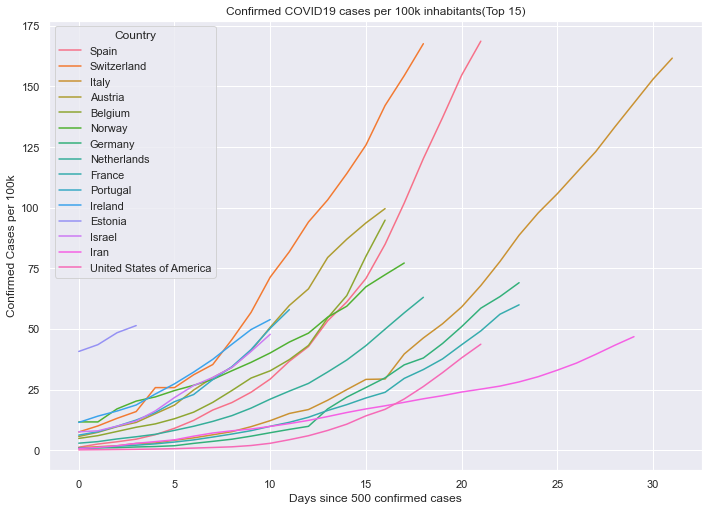

In [9]:
countries = larger_countries_cases_per_100k['geo_id'].head(15)
frames = [cases_per_100k_over_time(country, df) for country in countries]
plot_df = pd.concat(frames)

ax = sns.lineplot(
    x=plot_df.index, 
    y='cases_per_100k',
    hue='geo_name',
    legend='full',
    data=plot_df
)
ax.set(title='Confirmed COVID19 cases per 100k inhabitants(Top 15)')
ax.set(xlabel='Days since 500 confirmed cases')
ax.set(ylabel='Confirmed Cases per 100k')
labels = ax.get_legend().get_texts()
ax.legend(title='Country', loc='best', labels=[label.get_text() for label in labels[1:]])
plt.show()

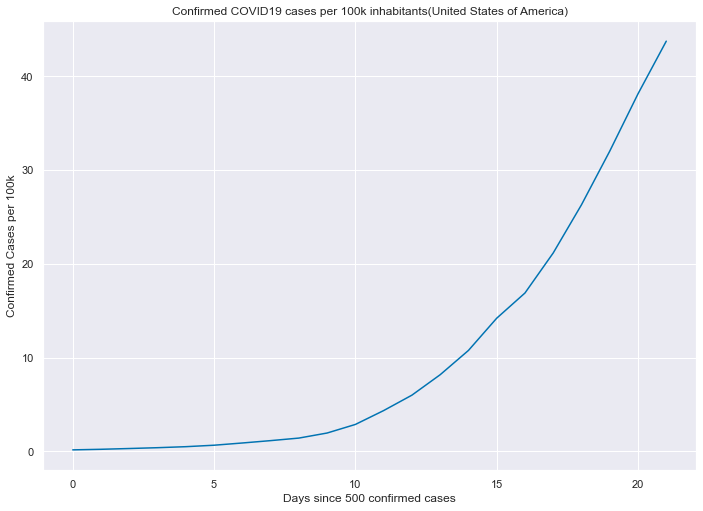

In [10]:
code = 'US'
lockdowns_for_country = lockdowns[lockdowns['country_code'] == code]
country = cases_per_100k_over_time(code, df).set_index('date').join(lockdowns_for_country).reset_index()
lockdown_days = country.index[country['country_code'] == code].to_list()
country_name = country.iloc[0]['geo_name']

ax = sns.lineplot(
    x=country.index, 
    y='cases_per_100k',
    legend='full',
    data=country
)

if len(lockdown_days) > 0:
    for lockdown_day in lockdown_days: 
        ax.axvline(lockdown_day, label="Lockdown", alpha=0.5, color='r', linestyle='--')
    
ax.set(title=f"Confirmed COVID19 cases per 100k inhabitants({country_name})")
ax.set(xlabel='Days since 500 confirmed cases')
ax.set(ylabel='Confirmed Cases per 100k')
plt.show()

## Deaths

In [11]:
# Only consider countries with at least 1m citizens
larger_countries_deaths_per_100k = aggregated[aggregated['pop_data_2018'] >= 10 ** 6]
larger_countries_deaths_per_100k = larger_countries_deaths_per_100k.sort_values(by=['deaths_per_100k'], ascending=False)
larger_countries_deaths_per_100k = rank_index(larger_countries_deaths_per_100k)

larger_countries_deaths_per_100k[['geo_name', 'deaths_per_100k', 'deaths', 'pop_data_2018']].head(60)

,geo_name,deaths_per_100k,deaths,pop_data_2018
1,Italy,17.840098,10781,6.043128e+07
2,Spain,13.971482,6528,4.672375e+07
3,Netherlands,4.474489,771,1.723102e+07
4,France,3.890293,2606,6.698724e+07
5,Belgium,3.773397,431,1.142207e+07
6,Iran,3.227373,2640,8.180027e+07
7,Switzerland,3.017656,257,8.516543e+06
8,United Kingdom,1.846922,1228,6.648899e+07
9,Denmark,1.241926,72,5.797446e+06
10,Portugal,1.157389,119,1.028176e+07


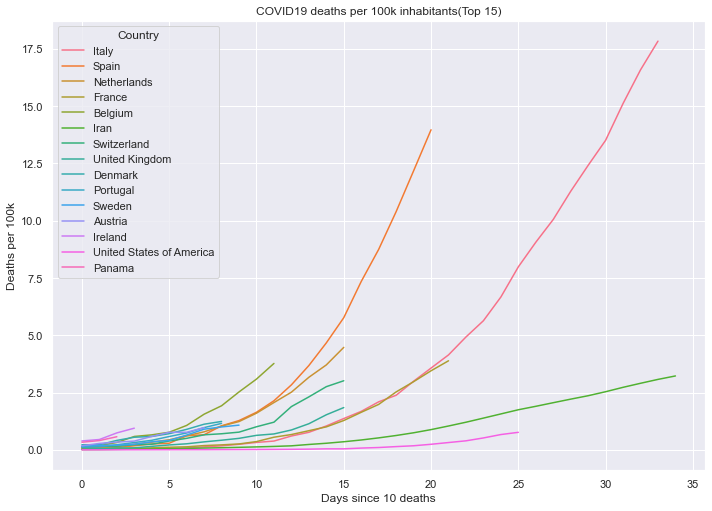

In [12]:
countries = larger_countries_deaths_per_100k['geo_id'].head(15)
frames = [deaths_per_100k_over_time(country, df) for country in countries]
plot_df = pd.concat(frames)

ax = sns.lineplot(
    x=plot_df.index, 
    y='deaths_per_100k',
    hue='geo_name',
    legend='full',
    data=plot_df
)
ax.set(title='COVID19 deaths per 100k inhabitants(Top 15)')
ax.set(xlabel='Days since 10 deaths')
ax.set(ylabel='Deaths per 100k')
labels = ax.get_legend().get_texts()
ax.legend(title='Country', loc='best', labels=[label.get_text() for label in labels[1:]])
plt.show()